In this notebook we used the fish tracks position information to calculate fish tilt (following Dunning et al., 2023) for the acoustic probe dataset.


In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob
import scipy as sc
import csaps

import sys, errno  


In [2]:

palette = sns.color_palette('colorblind')
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 13
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'

In [3]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
letter_drive = 'F'
WBATpath = f'{letter_drive}:/AFKABAN/WBAT_data_PNC2023/'



In [4]:
def tsf_targets_import(file_path):

    """
    This function imports wideband frequency response .csv files exported from
    Echoview and performs some basic housekeeping.
    
    PARAMETERS:
        file_path: Path to wideband frequency response .csv file from Echoview.
        
    RETURNS:
        df: Pandas dataframe.
    """
    
    def get_datetime(df, avg_flag):
        """
        Convert Echoview timestamps in imported .csv to datetime.
        """
        if avg_flag:
            df['Ping_microseconds_start'] = df.Ping_millisecond_start * 1000
            df['Ping_microseconds_start'] = [timedelta(microseconds = i) for i in df['Ping_microseconds_start']]
            df['Datetime'] = df['Ping_date_start_Ping_time_start'] + df['Ping_microseconds_start']
            df.drop(columns=['Ping_date_start_Ping_time_start',
                             'Ping_millisecond_start',
                             'Ping_microseconds_start'], 
                    inplace=True)
        
        else:
            df['Ping_microseconds'] = df.Ping_milliseconds * 1000
            df['Ping_microseconds'] = [timedelta(microseconds = i) for i in df['Ping_microseconds']]
            df['Datetime'] = df['Ping_date_Ping_time'] + df['Ping_microseconds']
            df.drop(columns=['Ping_date_Ping_time',
                             'Ping_milliseconds',
                             'Ping_microseconds'],
                    inplace=True)
        
        return df
    
    if "trackavg.csv" in file_path:
        parse_cols = ['Ping_date_start', 'Ping_time_start']
        ind_col = None
        avg_flag = True
        transpose = True
    if "target" in file_path:
        parse_cols = ['Ping_date', 'Ping_time']
        ind_col = None
        avg_flag = False
        transpose = False
    else:
        parse_cols = ['Ping_date', 'Ping_time']
        ind_col = 'Target_index'
        avg_flag = False
        transpose = True
        
    if transpose:
        transposed_path = file_path[:-4] + '_transposed.csv'
        if os.path.isfile(transposed_path) == True:
            df = pd.read_csv(transposed_path,
                             index_col=ind_col,
                             skiprows=1,
                             skipfooter=2,
                             engine='python',
                             parse_dates=[parse_cols])
        else:
            df = pd.read_csv(file_path, low_memory=False).T
            file_path = transposed_path
            df.to_csv(path_or_buf=file_path)
            print('A transposed TS(f) file was created at: \n' + str(file_path))    
            df = pd.read_csv(file_path,
                             index_col=ind_col,
                             skiprows=1,
                             skipfooter=2,
                             engine='python',
                             parse_dates=[parse_cols])
    else:
        df = pd.read_csv(file_path,
                 index_col=ind_col,
                 skiprows=0,
                 skipfooter=2,
                 engine='python',
                 parse_dates=[parse_cols])
    
    df = get_datetime(df, avg_flag)
    
    return df

## Combine target and track data
For the tilt calculations, we need information on the track, the major and minor axis angles and range. These informations are found in different Echoview exports. 

Here I combine the:
- from the SED echogram -> Single targetss to CSV..,
- Analysis by region, Wideband frequency response...


In [5]:
def join_targettracks(path):
    """
    This function imports wideband frequency response of tracks and single target export .csv files exported from
    Echoview and combines them to match data on target spectra, track and in-beam target position.
    
    PARAMETERS:
        path: Path to wideband frequency response + single target .csv file from Echoview.
        
    RETURNS:
        targettracks_df: Pandas dataframe.
    """
    
    # Determine paths
    tracks_path = path+"SED_tsf_tracks.csv"
    target_path = path+'all_SED.target.csv'
    
    # Read tracks import (from Export by Regions -> Wideband frequecy response (both frequencies))
    tracks_df = tsf_targets_import(tracks_path)
    
    # replace -99999 with nan
    ts_s = np.where(tracks_df.columns.values=='90.000')[0][0]
    ts_e = np.where(tracks_df.columns.values=='255.565')[0][0]
    tracks_ts = tracks_df.iloc[:,ts_s:ts_e+1]
    tracks_ts[tracks_ts<-99999]=np.nan
    tracks_df.iloc[:,ts_s:ts_e+1] = tracks_ts
    
    # Change column names to match 
    tracks_df = tracks_df.rename(columns={'Ping_index':'Ping_number','Range':'Target_range'})
    
    # Read target info (from Single target to csv. includes ALL SED)
    target_df = tsf_targets_import(target_path)

    # Select columns to keep
    target_df = target_df[['Ping_number', 'Target_range', 'Angle_minor_axis', 'Angle_major_axis', 'TS_comp']]
    # Match multi index
    tracks = tracks_df.set_index(['Ping_number','Target_range'])
    target = target_df.set_index(['Ping_number','Target_range'])
    # Join dataframes for target position and ts(f) for SED in tracks|
    new_df = tracks.join(target)
    targettracks_df = new_df.reset_index()
    
    targettracks_df = targettracks_df.sort_values(['Region_name','Ping_number'])
    
    return targettracks_df

In [7]:
WBAT_df = join_targettracks(WBATpath)

In [8]:
WBAT_df

,Ping_number,Target_range,Depth,Region_name,90.000,92.016,94.032,96.048,98.065,100.081,...,245.484,247.500,249.516,251.532,253.548,255.565,Datetime,Angle_minor_axis,Angle_major_axis,TS_comp
0,227,20.753672,20.733599,Region 332,NaN,NaN,NaN,NaN,NaN,NaN,...,-69.646619,-68.437977,-66.368509,-64.908318,-64.869053,-66.293637,2023-01-21 19:30:26.026,-0.24333,2.50840,-68.693092
1,228,20.887830,20.870145,Region 332,-68.955891,-63.388328,-63.420573,-64.981513,-64.249529,-63.847835,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-21 19:30:28.274,2.12590,-1.02090,-67.342796
2,229,20.858665,20.841497,Region 332,NaN,NaN,NaN,NaN,NaN,NaN,...,-67.829689,-69.263223,-69.442860,-68.500416,-68.578998,-69.922833,2023-01-21 19:30:30.347,1.24640,1.96300,-68.956133
3,230,20.946159,20.931581,Region 332,-67.319863,-64.031784,-63.831477,-63.714838,-63.445348,-63.834957,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-21 19:30:32.594,0.96147,-1.90970,-68.256776
4,231,20.998656,20.967919,Region 332,NaN,NaN,NaN,NaN,NaN,NaN,...,-66.140333,-68.817256,-68.504470,-65.431003,-67.360366,-70.178799,2023-01-21 19:30:34.676,2.72940,1.47300,-68.667579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,159,45.782903,45.769429,Region 404,NaN,NaN,NaN,NaN,NaN,NaN,...,-71.982802,-72.268632,-77.254173,-75.622214,-78.272791,-75.291095,2023-01-21 19:27:58.697,0.55866,-1.27300,-71.797798
481,160,45.771237,45.755322,Region 404,-67.941818,-71.623788,-74.334591,-69.576660,-71.693984,-74.604128,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-21 19:28:00.954,-1.49810,0.19662,-72.875361
482,161,45.887896,45.852274,Region 404,NaN,NaN,NaN,NaN,NaN,NaN,...,-69.061268,-66.941137,-65.812279,-63.820026,-61.588265,-73.403627,2023-01-21 19:28:03.036,1.32670,-1.82750,-68.559086
483,162,45.905395,45.857042,Region 404,-59.881459,-60.465282,-65.967149,-66.042884,-66.327798,-65.724916,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-21 19:28:05.284,-2.62570,0.15095,-71.123069


## Calculate parameters for tilt calculations
Following equations and assumptions from Dunning et al. (2023):
- $x = ztan(\theta)$
- $y = ztan(\phi)$
- $z = \sqrt{(r^2 - (x^2 + y^2))}$ -> - $z = \sqrt{r^2 \over tan^2(\theta)+tan^2(\phi)+1}$,


where $\theta$ is alongship (minor axis) angle and $\phi$ is athwartship (major axis) angle. and r is the range


The tilt angle is calculated by the elevation ($\alpha$) between two points. We calculate it through the projection on the XY plane and the distance elevations.
 $\tan{z_2-z_1 \over \sqrt{(x_2-x_1)^2+(y_2-y_1)^2}}$

In [9]:
def calculate_tilt(df):
    
    # Calculate xyz coordinates from range and position in beam
    rad_minor = np.deg2rad(df['Angle_minor_axis'])
    rad_major = np.deg2rad(df['Angle_major_axis'])
    df['z'] = -np.sqrt(df['Target_range']**2/((np.tan(rad_minor)**2)+(np.tan(rad_major)**2)+1))
    df['x'] = df['z']*np.tan(rad_minor)
    df['y'] = df['z']*np.tan(rad_major)

    alpha = np.zeros(len(df))*np.nan
    tilt = np.zeros(len(df))*np.nan
    
    # Select a track
    n_tracks = df['Region_name'].unique()
    for i_track in range(len(n_tracks)):
        track_inds = np.where(df['Region_name']==n_tracks[i_track])[0]
        
        # No smoothing by cubic spline, we found this added more variability in the values and increased the spread of the data.
        for i in track_inds[:-1]:
            # Calculate distance from i
            del_x = df['x'].iloc[i+1] - df['x'].iloc[i]
            del_y = df['y'].iloc[i+1] - df['y'].iloc[i]
            del_z = df['z'].iloc[i+1] - df['z'].iloc[i]

            # Projection of distance on XY plane
            del_xy = np.sqrt(del_x**2+del_y**2)
            
            # Angle of XY distance and elevation
            alpha[i] = np.rad2deg(np.arctan2(del_z,del_xy))
        
        # tilt at i is average of alpha between [i-1,i] and [i,i+1]
        for i in track_inds[1:-1]:
            tilt[i] = np.mean([alpha[i-1:i+1]])

    # First and last detections in a track should be NaN
    df['tilt'] = tilt
    df['alpha'] = alpha
    
    return df

In [10]:
WBAT_tilt_df = calculate_tilt(WBAT_df)


In [11]:
# remove bandwidth 162 to 170 kHz
bad_s = np.where(WBAT_tilt_df.columns.values=='160.565')[0][0]
bad_e = np.where(WBAT_tilt_df.columns.values=='170.645')[0][0]

WBAT_tilt_df.iloc[:,bad_s:bad_e+1]=np.nan


# remove 90-94 kHz
bad_s = np.where(WBAT_tilt_df.columns.values=='90.000')[0][0]
bad_e = np.where(WBAT_tilt_df.columns.values=='94.032')[0][0]

WBAT_tilt_df.iloc[:,bad_s:bad_e+1]=np.nan

# remove bandwidth 185-189 kHz
bad_s = np.where(WBAT_tilt_df.columns.values=='185.000')[0][0]
bad_e = np.where(WBAT_tilt_df.columns.values=='189.032')[0][0]

WBAT_tilt_df.iloc[:,bad_s:bad_e+1]=np.nan

# remove 251-255 kHz
bad_s = np.where(WBAT_tilt_df.columns.values=='251.532')[0][0]
bad_e = np.where(WBAT_tilt_df.columns.values=='255.565')[0][0]

WBAT_tilt_df.iloc[:,bad_s:bad_e+1]=np.nan


In [12]:
WBAT_tilt_df = WBAT_tilt_df.reset_index()

In [13]:
WBAT_tilt_df.to_feather(f'{WBATpath}/WBAT_tilt_df.feather')


### Plot mean of all targets in tracks

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


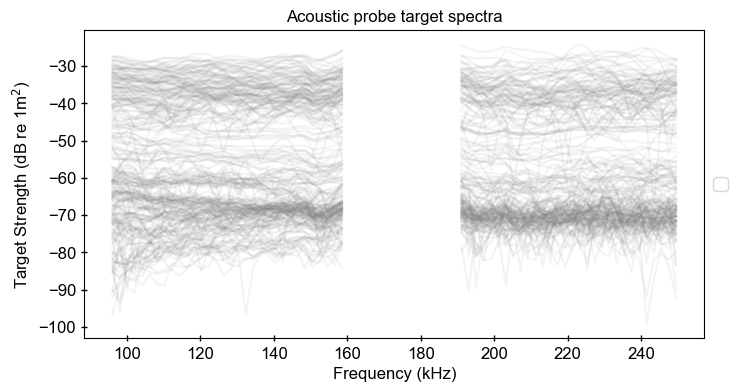

In [14]:
fig,ax = plt.subplots(1,1, figsize=(8,4))

# calculate median tilt for intervals of 10 degrees tilt
df = WBAT_df



ts_s = np.where(df.columns.values=='90.000')[0][0]
ts_e = np.where(df.columns.values=='255.565')[0][0]

df_ts = df.iloc[:,ts_s:ts_e+1]
# remove spectra with poor calibration results removed 161-170 kHz

freqs = df_ts.columns.unique().values.astype(np.float64)
# Plot median and CI
ax.plot(freqs,df_ts.T, 'grey', alpha=0.09)
#ax.fill_between(freqs,df_ts.quantile(q=0.25),df_ts.quantile(q=0.75),alpha=0.2)


ax.set_ylabel('Target Strength (dB re 1m$^2$)', fontsize=12)
ax.set_title('Acoustic probe target spectra', fontsize=12)
ax.set_xlabel('Frequency (kHz)', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=13)
    
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/PhDdocs/ConferencesMeetings/WGFAST2023/target_spectra.jpeg', format='jpeg', dpi = 300, facecolor='w', bbox_inches='tight', transparent=True)

Observations:
- It seems that a threshold at -60 dB could be used to discriminate between Northen shrimp and polar or Atlantic cod. 
- High variability in broadband target spectra, largest for Atlantic cod (~10 dB)
- Both Polar cod medians follow same pattern. Atlantic cod is very similar but slight differences

### Plot distribution of tilt for all SED in tracks

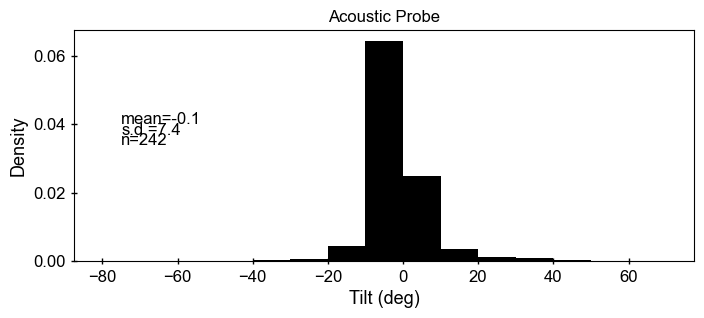

In [15]:
## set up bins
bin_array = np.arange(-80,80,10) 
fig, ax = plt.subplots(1,1, figsize=(8,3), sharex=True, sharey=True)

df = WBAT_df
ax.hist(df['tilt'], bins = bin_array, density=True, color='k')
ax.set_title('Acoustic Probe')
ax.text(-75,0.04,'mean=%.1f' %np.mean(df['tilt']))
ax.text(-75,0.037,'s.d.=%.1f' %np.std(df['tilt']))
ax.text(-75,0.034,'n=%.0f' %(len(df['tilt'])/2))
ax.set_ylabel('Density')
ax.set_xlabel('Tilt (deg)');


### Plot median target spectra at different orientations

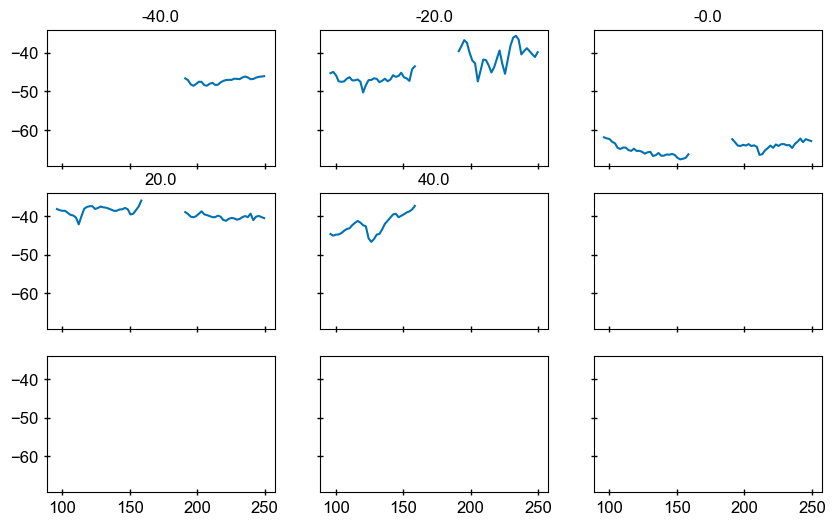

In [16]:
## Plot by tilt
fig,ax = plt.subplots(3,3, figsize=(10,6), sharex=True, sharey=True)
axes = ax.flatten()

# calculate median tilt for intervals of 10 degrees tilt.
df = WBAT_df
df['tilt_20'] = 20* (df['tilt']/20).round()
df_tilt_20 = df.groupby(['tilt_20']).median(numeric_only=True)

ts_s = np.where(df.columns.values=='90.000')[0][0]
ts_e = np.where(df.columns.values=='255.565')[0][0]
freqs = df_tilt_20.columns.unique()[ts_s:ts_e].values.astype(np.float64)


for i_tilt in range(len(df_tilt_20.index)):
    axes[i_tilt].plot(freqs,df_tilt_20.iloc[i_tilt,ts_s:ts_e].T)
    axes[i_tilt].set_title(df_tilt_20.index[i_tilt])

Target spectra at high angles seem to have more peaks and nulls but there are also less targets to smooth over, so it is not necessarily more teaxtures spectra

(-110.0, -20.0)

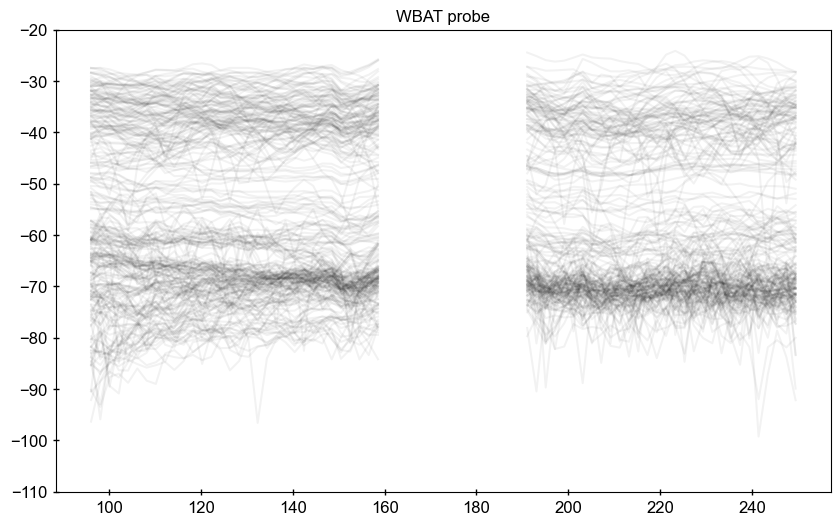

In [18]:
## Plot all
df = WBAT_df
fig, ax = plt.subplots(1,1, figsize=(10,6), sharex=True, sharey=True)

# calculate median tilt for intervals of 10 degrees tilt.
ts_s = np.where(df.columns.values=='90.000')[0][0]
ts_e = np.where(df.columns.values=='255.565')[0][0]
df_ts = df.iloc[:,ts_s:ts_e]

freqs = df_ts.columns.values.astype(np.float64)

ax.plot(freqs,df_ts.T, alpha=0.05, color='k')
ax.set_title('WBAT probe')
ax.set_ylim([-110,-20])

In [19]:
WBAT_df

,Ping_number,Target_range,Depth,Region_name,90.000,92.016,94.032,96.048,98.065,100.081,...,Datetime,Angle_minor_axis,Angle_major_axis,TS_comp,z,x,y,tilt,alpha,tilt_20
0,227,20.753672,20.733599,Region 332,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-01-21 19:30:26.026,-0.24333,2.50840,-68.693092,-20.733599,0.088054,-0.908294,NaN,-5.054543,NaN
1,228,20.887830,20.870145,Region 332,NaN,NaN,NaN,-64.981513,-64.249529,-63.847835,...,2023-01-21 19:30:28.274,2.12590,-1.02090,-67.342796,-20.870144,-0.774720,0.371905,-1.802929,1.448685,-0.0
2,229,20.858665,20.841497,Region 332,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-01-21 19:30:30.347,1.24640,1.96300,-68.956133,-20.841498,-0.453453,-0.714326,-1.095822,-3.640329,-0.0
3,230,20.946159,20.931581,Region 332,NaN,NaN,NaN,-63.714838,-63.445348,-63.834957,...,2023-01-21 19:30:32.594,0.96147,-1.90970,-68.256776,-20.931581,-0.351282,0.697920,-2.565331,-1.490332,-0.0
4,231,20.998656,20.967919,Region 332,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-01-21 19:30:34.676,2.72940,1.47300,-68.667579,-20.967919,-0.999605,-0.539177,-1.167026,-0.843720,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,159,45.782903,45.769429,Region 404,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-01-21 19:27:58.697,0.55866,-1.27300,-71.797798,-45.769429,-0.446287,1.017074,-0.953950,0.400226,-0.0
481,160,45.771237,45.755322,Region 404,NaN,NaN,NaN,-69.576660,-71.693984,-74.604128,...,2023-01-21 19:28:00.954,-1.49810,0.19662,-72.875361,-45.755323,1.196627,-0.157018,-0.798752,-1.997730,-0.0
482,161,45.887896,45.852274,Region 404,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-01-21 19:28:03.036,1.32670,-1.82750,-68.559086,-45.852274,-1.061912,1.462995,-1.037457,-0.077183,-0.0
483,162,45.905395,45.857042,Region 404,NaN,NaN,NaN,-66.042884,-66.327798,-65.724916,...,2023-01-21 19:28:05.284,-2.62570,0.15095,-71.123069,-45.857041,2.102968,-0.120814,0.062769,0.202721,0.0
